## Predicting User Knowledge Levels 

Group 40 Members: Sam Kao, Namya Sharma, Yulu Duan, Jason Zhou

### Introduction:

A person’s level of knowledge cannot be evaluated unilaterally, and different people with varying knowledge levels could be assigned a more appropriate job in a firm, based on their knowledge level, in order do their own work efficiently. The User Knowledge dataset covers six variables: STG (The degree of study time for goal object materials), SCG (The degree of repetition number of user for goal object materials), STR (The degree of study time of user for related objects with goal object), LPR (The exam performance of user for related objects with goal object), PEG (The exam performance of user for goal objects), and UNS (an individual’s knowledge level). There are a total of 403 observations and the first five variables are all numerical doubles, whereas UNS is a categorical variable. 
As the time passes, the global job market becomes more competitive than before. Thousands of people with differing strengths compete for the same job; therefore, we need a model to select applicants most efficiently. Such a model can alleviate stress from a corporation's recruitment team.

Question: What will the knowledge level (UNS) of a user be (very low, low, middle or high) based on their exam performance of goal object (PEG)?

### Preliminary exploratory data analysis:

In [7]:
library(tidyverse)
library(tidymodels)
library(readxl)
library(dplyr)
library(gridExtra)
options(repr.matrix.max.rows = 6)

In [8]:
# reading the data
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/00257/Data_User_Modeling_Dataset_Hamdi%20Tolga%20KAHRAMAN.xls"
download.file(url, "data.xls")
training_data <- read_excel("data.xls", sheet = 2) # sheet 2 => training data

# select only the columns we need and making our class as a factor
training_data <- training_data %>%
    select(1:6) %>%
    mutate(UNS = as_factor(UNS))

training_data

New names:
* `` -> ...7
* `` -> ...8



STG,SCG,STR,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0.00,0.00,0.00,0.00,0.00,very_low
0.08,0.08,0.10,0.24,0.90,High
0.06,0.06,0.05,0.25,0.33,Low
⋮,⋮,⋮,⋮,⋮,⋮
0.54,0.82,0.71,0.29,0.77,High
0.50,0.75,0.81,0.61,0.26,Middle
0.66,0.90,0.76,0.87,0.74,High


In [9]:
# summarize the training data, counting how many occurences of each class 
num_of_class <- training_data %>%
    mutate(UNS = factor(UNS, levels = c("High", "Middle", "Low", "very_low"))) %>%
    count(UNS)

num_of_class

UNS,n
<fct>,<int>
High,63
Middle,88
Low,83
very_low,24


In [11]:
#the means of the predictor variables in your dataset
predictors_mean <- training_data %>%
                  summarize (mean_STG = mean(STG, na.rm = TRUE),
                             mean_SCG = mean(SCG, na.rm = TRUE),
                             mean_STR = mean(STR, na.rm = TRUE),
                             mean_LPR = mean(SCG, na.rm = TRUE),
                             mean_PEG = mean(PEG, na.rm = TRUE))
predictors_mean

mean_STG,mean_SCG,mean_STR,mean_LPR,mean_PEG
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.3711473,0.3556744,0.4680039,0.3556744,0.4585388


In [27]:
#how many rows have missing data
missing_data <- training_data %>% 
        filter(is.na(STG), is.na(PEG), is.na(SCG), is.na(STR), is.na(LPR), is.na(UNS)) %>%
        nrow()
missing_data

[1] 0

In [54]:
#compare the distributions of each of the predictor variables you plan to use in your analysis
#the distribution of exam performace of goal objects
options(repr.plot.width = 15, repr.plot.height = 12) 
distr_PEG <- training_data %>%
    mutate(UNS = factor(UNS, levels = c("High", "Middle", "Low", "very_low"))) %>% 
    ggplot(aes(x = PEG, fill = UNS)) +
    geom_histogram(binwidth = .01)+
    labs(x = "Exam performance of goal objects", fill = "The knowledge level of user")+
    ggtitle("PEG vs UNS distribution")+
    theme(text = element_text(size= 18))+
    facet_grid(rows = vars(UNS))

In [55]:
#compare the distributions of each of the predictor variables you plan to use in your analysis
#The distribution of the degree of study time for goal object materails (STG)
options(repr.plot.width = 15, repr.plot.height = 12) 
distr_STG <- training_data %>%
    mutate(UNS = factor(UNS, levels = c("High", "Middle", "Low", "very_low"))) %>%
    ggplot(aes(x = STG, fill = UNS)) +
    geom_histogram(binwidth = .01)+
    labs(x = "Study time for goal object materails", fill = "The knowledge level of user")+
    ggtitle("STG vs UNS distribution")+
    theme(text = element_text(size= 18))+
    facet_grid(rows = vars(UNS))

In [56]:
#compare the distributions of each of the predictor variables you plan to use in your analysis
#The degree of repetition number of user for goal object materials (SCG)
options(repr.plot.width = 15, repr.plot.height = 12) 
distr_SCG <- training_data %>%
    mutate(UNS = factor(UNS, levels = c("High", "Middle", "Low", "very_low"))) %>%
    ggplot(aes(x = SCG, fill = UNS)) +
    geom_histogram(binwidth = .01)+
    labs(x = "Degree of repition for goal object materails", fill = "The knowledge level of user")+
    ggtitle("SCG vs UNS distribution")+
    theme(text = element_text(size= 18))+
    facet_grid(rows = vars(UNS))

In [49]:
#compare the distributions of each of the predictor variables you plan to use in your analysis
#The degree of study time of user for related objects with goal object (STR)
options(repr.plot.width = 10, repr.plot.height = 10) 
distr_STR <- training_data %>%
    mutate(UNS = factor(UNS, levels = c("High", "Middle", "Low", "very_low"))) %>%
    ggplot(aes(x = STR, fill = UNS)) +
    geom_histogram(binwidth = .01)+
    labs(x = "Degree of study time for goal object materails", fill = "The knowledge level of user")+
    ggtitle("STR vs UNS distribution")+
    theme(text = element_text(size= 18))+
    facet_grid(rows = vars(UNS))

In [57]:
#compare the distributions of each of the predictor variables you plan to use in your analysis
#The exam performance of user for related objects with goal object (LPR)
options(repr.plot.width = 15, repr.plot.height = 12) 
distr_LPR <- training_data %>%
    mutate(UNS = factor(UNS, levels = c("High", "Middle", "Low", "very_low"))) %>%
    ggplot(aes(x = LPR, fill = UNS)) +
    geom_histogram(binwidth = .01)+
    labs(x = "Exam performance of related object", fill = "The knowledge level of user")+
    ggtitle("LPR vs UNS distribution")+
    theme(text = element_text(size= 18))+
    facet_grid(rows = vars(UNS))

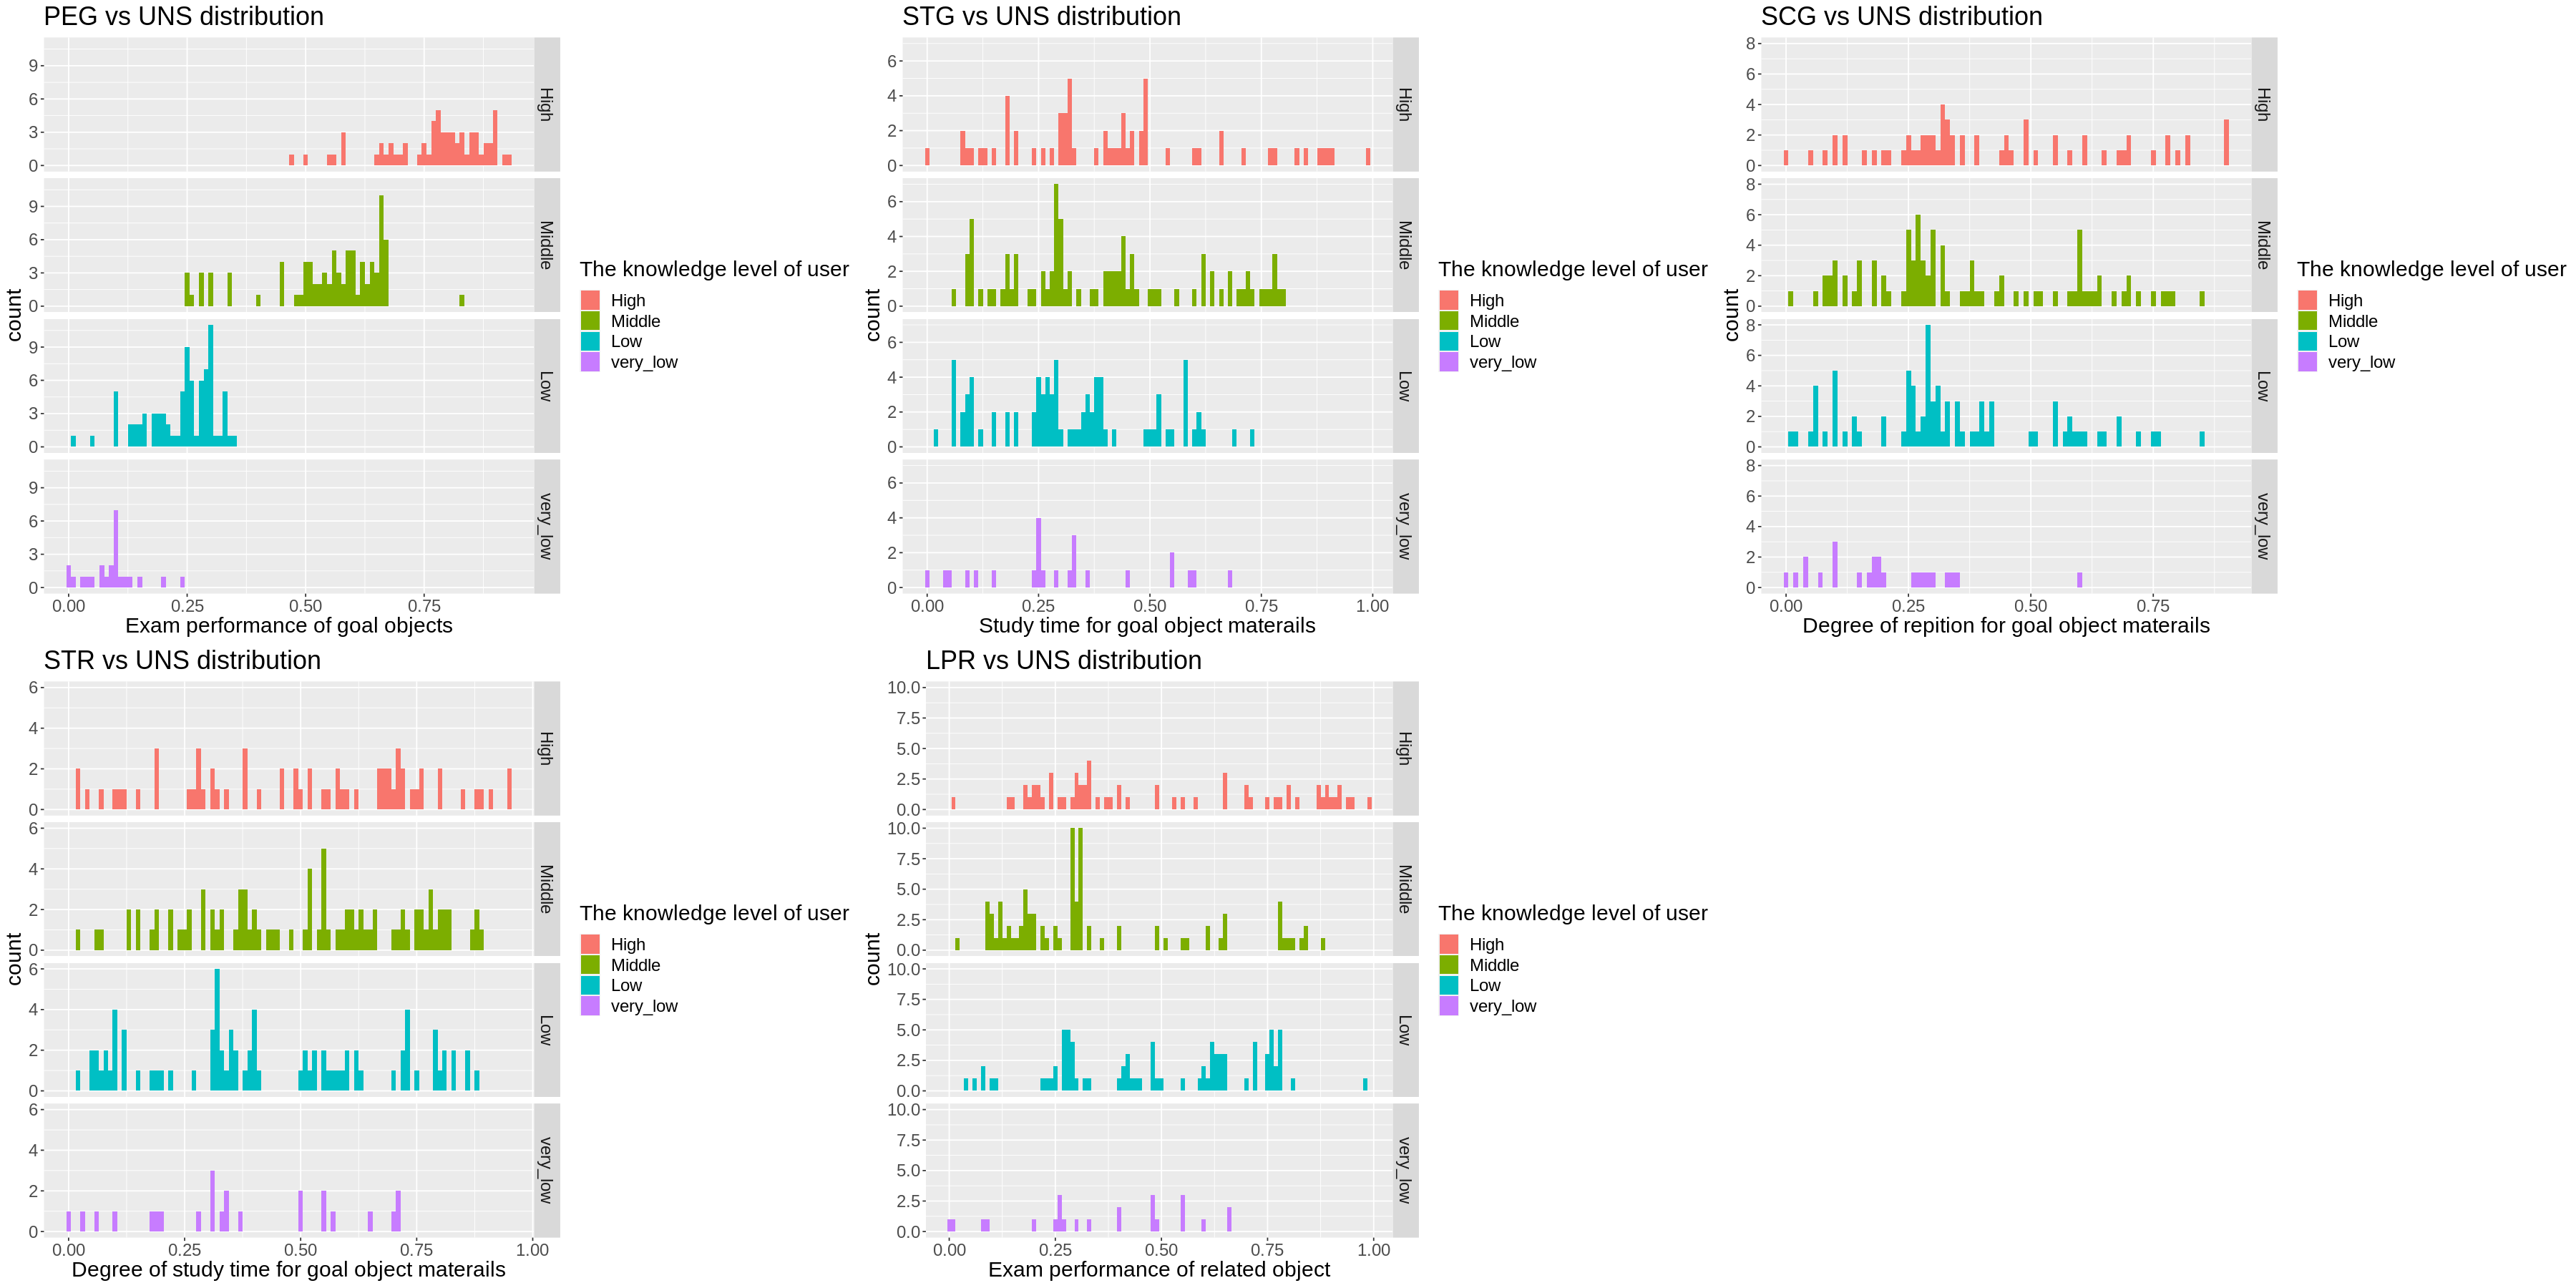

In [58]:
#compare the distributions of each of the predictor variables you plan to use in your analysis
library(cowplot)
options(repr.plot.width = 30, repr.plot.height = 15)
plot_grid(distr_PEG, distr_STG, distr_SCG, distr_STR, distr_LPR)
options(repr.plot.width = 30, repr.plot.height = 15)

### Methods:

In our model, we will use only the variable PEG (the exam performance of users for goal objects) to classify UNS (an individual’s knowledge level). We decided to use only PEG as our predictor since only the PEG distribution shows higher knowledge level with higher exam performance, hence PEG was the only major variable influencing one's knowledge level. All other variables seemed to have little to no effect on knowledge level which is seen since the histograms had too large of a spread for each class. Additionally, we believe that using other variables in combination with PEG as predictors will lower our model's accuracy; thus, we will use the sole predictor PEG to build our k-nearest neighbours classification model. We will also tune our model to select the best ‘k’ value for our model by performing cross validation before applying our fitted model to our testing dataset, from which we can determine its accuracy. After acquiring a satisfactory accuracy value, our final test will be to use our own model to predict one's knowledge level given an arbitrary PEG value. To visualize our results, we will plot a histogram with four bars indicating each knowledge level, with their respective average exam performance on the y-axis. Our "new" point will plot a horizontal line representing an exam score, from which we will predict a knowledge category.

### Expected outcomes and significance:

Due to the strong relationship of PEG and UNS as visualized in our preliminary analysis, we expect our model to be able to label the knowledge level of a user based on PEG to an accurate degree. Those with higher PEG values will have a higher UNS classification and vice versa. These findings can allow us to predict an individual’s knowledge level based on exam performance, and if reliable enough, our model could be applied in the real world by companies to hire individuals based on their exam performance and knowledge levels. Future questions could explore the different variables in the dataset (e.g. how do different combinations of predictors affect the accuracy of the model, and can we predict variables such as PEG using other variables).  